# RETENTION CURVES FORMULATION 

In this Jupyter Notebook, we will derive and implement the constitutive equations that define soil-water retention curve models, specifically focusing on the formulation by [van Genuchten (1980)](https://www.researchgate.net/publication/250125437_A_Closed-form_Equation_for_Predicting_the_Hydraulic_Conductivity_of_Unsaturated_Soils1). 

Additionally, we will solve an exercise related to multiphase flow, applying these models to deepen our understanding of unsaturated soil behavior.

<br>

### Water content, $\Theta$:
 - **Dimensionless water content**

$$ \Theta = {\theta - \theta_{r} \over \theta_{s} - \theta_{r}}$$

where,

$\theta$ soil-water content (t, in the code)

$\theta_{s}$ satured values of the soil-water content (ts, in the code) 

$\theta_{r}$ residual values of the soil-water content (tr, in the code)

<br>

 - **Dimensionless water content related to the pressure head**

$$ \Theta = \left[{1 \over 1 + (\alpha h)^{n}}\right] $$

where,

$h$ pressure head (h in the code)

$\alpha$ is related to the inverse of the air entry suction (a in the code)

$n$ is a mesure of the pore-size distribution (n in the code)

<br>

 - **Merging the first two equations, we can derive the retention curve as**

$$ \theta = \theta_{r} + {(\theta_{s} - \theta_{r}) \over \left[1 + (\alpha h)^{n}\right]^{m}} \space\space\space\space (m = 1 - 1/n) $$

where,

$m$ is defined as $1 - (1/n)$ (m in the code)

<br>

### Relative Hydraulic Conductivity, $K_{r}$:
 - **Relative Hydraulic Conductivity expressed in terms of the dimensionless water content**

$$ K_{r}(h) = { \{ 1 - (\alpha h)^{n-1} \space \left[ 1 + (\alpha h)^{n} \right]^{-m} \}^{2} \over  \left[1 + (\alpha h)^{n}\right]^{m/2} } \space\space\space\space (m = 1 - 1/n) $$

Where,
 
$K_{r}$ relative hydraulic conductivity (Kr, in the code)

<br>

 - **Relative Hydraulic Conductivity expressed in terms of the dimensionless pressure head**

$$ K_{r}(\Theta) = \Theta^{1/2} \left[1 - \left(1 - \Theta^{1/m}\right)^{m} \right]^{2} \space\space\space\space (m = 1 - 1/n\space\space\& \space\space 0 \gt m \gt 1) $$

<br>

### Diffusivity, $D$:

$$ D(\Theta) = {(1 - m)K_s  \over \alpha m (\theta_{s} - \theta_{r})} \Theta^{1/2 - 1/m} \left[\left( 1 - \Theta^{1/m} \right)^{-m} + \left( 1 - \Theta^{1/m} \right)^{m} - 2 \right] $$

where,

$K_{s}$ is the hydraulic conductivity at saturation (= $K/K_{r}$)

<br>
<br>
<br>

### Coding the equations from van Genuchten, 1980

#### Importing the needed libraries

In [3]:
#-- Check and install required packages if not already installed --#
import sys
import subprocess

def if_require(package):
    try:
        __import__(package)
    except ImportError:
        print(f"{package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        
#-- Install packages only if they aren't already installed --#
if_require("ipywidgets")

#-- Import the rest of libraries --#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore")

#### Coding the equations as functions

In [4]:
def m_val(n):
    """Function that returns the value of "m"

    Parameters
    ----------
    n : float
        value of "n"

    Returns
    -------
    float
        value of "m"
    """
    
    m = 1 - (1/n)

    return m


def dimensionless_water_content(t, tr, ts):
    """Function that calculates the dimensionless water content. 
    
    Based on van Genuchten, 1980 (Eq. 2) 

    Parameters
    ----------
    t : float
        soil-water content
    tr : float
        residual values of soil-water content
    ts : float
        saturated values of soil-water content

    Returns
    -------
    float
        dimensionless water content
    """
    
    T_dim = (t - tr)/(ts - tr)      

    return T_dim


def water_content(alpha, h, n):  
    """Function that calculates the water content. 
    
    Based on van Genuchten, 1980 (Eq. 3)

    Parameters
    ----------
    alpha : float
        alpha parameter
    h : float
        head pressure
    n : float
        n parameter

    Returns
    -------
    float
        water content
    """
    
    T = ((1 + (alpha*h)**(n)))**(-(m_val(n)))  

    return T


def soil_water_content(tr, ts, alpha, h, n):
    """Function that calculates the soil-water content.
    
    Based on van Genuchten, 1980 (Eq. 21)

    Parameters
    ----------
    tr : float
        residual values of soil-water content
    ts : float
        saturated values of soil-water content
    alpha : float
        alpha parameter
    n : float
        n parameter
    
    Returns
    -------
    float
        soil-water content
    """

    t = tr + ((ts - tr) / ((1 + (alpha*h)**(n))**m_val(n)))   

    return t
    

def relative_hydraulic_conductivity(alpha, n, h, T):
    """Function that calculates the relative hydraulic conductivity. 

    Based on van Genuchten, 1980 (Eq. 8 and 9).

    Parameters
    ----------
    alpha : float
        alpha parameter
    n : float
        n parameter
    h : float 
        head pressure

    Returns
    -------
    T: float
        _description_
    Kr_T: float
        relative hydraulic conductivity expressed in terms of the dimensionless water content
    Kr_h: float
        relative hydraulic conductivity expressed in terms of the head pressure  
    T : float
        water content 

    Raises
    ------
    ValueError
        If m value is not between 0 and 1
    """
   
    # Check that m_val(n) is within the expected range
    if not (0 < m_val(n) < 1):
        raise ValueError("Parameter 'm' out of range: must be between 0 and 1")

    #-- Relative hydraulic conductivity expressed in terms of the water content
    Y = (1 - T**(1 / m_val(n)))**m_val(n)
    Kr_T = T**0.5 * (1 - Y)**2                     
    
    #-- Relative hydraulic conductivity expressed in terms of the pressure head
    I = (1 - alpha * h)
    U = I**(n - 1)
    P = (1 + (alpha * h)**n)**(m_val(n) / 2)
    
    if I > 0:
        Kr_h = ((U * T)**2) / P 
    else:
        Kr_h = np.nan                        
    
    return Kr_T, Kr_h


def soil_water_diffusivity(Ks, n, ts, tr, T):
    """Function that calculates the soil water diffusivity.

    Based on van Genuchten, 1980 (Eq. 11).

    Parameters
    ----------
    Ks : float
        hydraulic conductivity at saturation
    n  : float
        n parameter
    ts : float
        satured soil-water content
    tr : float
        residual soil-water content
    T : float
        dimensionless water content

    Returns
    -------
    D_T : float
        soil water diffusivity
    """
    
    I = ((1 - m_val(n))*Ks) / (alpha*m_val(n)*(ts - tr))
    L = T**(0.5 - (1/m_val(n)))
    Y = (1 - T**(1 / m_val(n)))**m_val(n)
    P = ((1/Y) + (Y) - 2)
    D_T = I * L * P                                        

    return D_T

### Multiphase Flow Exercices

Consider the following retention curve measurements of the water/air system and permeability of a soil sample composed of silts and sands. It is known that the saturated hydraulic conductivity _Ks_ ​is 4.96 cm/day and that the residual volumetric water content $\theta_{r}$ is 0.131 and the satured value of soil-water content $\theta_{s}$ is 0.396.

\begin{array}{|l l|l l|}
\hline
\text{|hc| (cm)} & \text{$\theta$} & \text{K/Ks} & \text{|hc| (cm)}\\
\hline
\text{0}        & \text{0.396}      & \text{1.0}        & \text{0.0}\\
\hline
\text{10}       & \text{0.396}      & \text{1.0}        & \text{11.5}\\
\hline
\text{20}       & \text{0.394}      & \text{0.95}       & \text{16.5}\\
\hline
\text{43}       & \text{0.390}      & \text{0.90}       & \text{19.6}\\
\hline
\text{60}       & \text{0.3855}     & \text{0.765}      & \text{30.0}\\
\hline
\text{80}       & \text{0.379}      & \text{0.585}      & \text{50.0}\\
\hline
\text{111}      & \text{0.370}      & \text{0.480}      & \text{70.0}\\
\hline
\text{190}      & \text{0.340}      & \text{0.338}      & \text{100.0}\\
\hline
\text{285}      & \text{0.300}      & \text{0.200}      & \text{138.0}\\
\hline
\text{400}      & \text{0.260}      & \text{0.100}      & \text{186.0}\\
\hline
\text{600}      & \text{0.220}      & \text{0.074}      & \text{200.0}\\
\hline
\text{800}      & \text{0.200}      & \text{0.030}      & \text{257}\\
\hline
\text{900}      & \text{0.194}      & \text{0.010}      & \text{339}\\
\hline
\text{100}      & \text{0.190}      & \text{}           & \text{}\\
\hline
\end{array}

##### What do we know?

In [5]:
#-----------------------------------#
# From the table to a dataframe     #
#-----------------------------------#

#-- pressure head vs water content --#
retentionCurve = pd.DataFrame()
retentionCurve["Pressure Head"] = [0, 10, 20, 43, 60, 80, 111, 190, 285, 400, 600, 800, 900, 1000]
retentionCurve["Water Content"] = [0.396, 0.396, 0.394, 0.390, 0.3855, 0.379, 0.370, 0.340, 0.300, 0.260, 0.220, 0.200, 0.194, 0.190]

#-- K/Ks vs pressure head --#
relativeK = pd.DataFrame()
relativeK["Relative Hydraulic Conductivity"] = [1, 1, 0.95, 0.9, 0.765, 0.595, 0.480, 0.338, 0.200, 0.100, 0.074, 0.03, 0.01]
relativeK["Pressure Head"] = [0, 11.5, 16.5, 19.6, 30, 50, 70, 100, 138, 186, 200, 257, 339]

#### a) Fit the retention curve and find the parameters $\alpha$ (cm<sup>-1</sup>) and $n$ of van Genuchten

In [6]:
params = {}
def find_parameters(tr, ts, alpha, n):
    """Calculates, fits and visualizes the soil-water retention curve using the Van Genuchten model.
    
    Parameters
    ----------
    tr : float
        residual soil-water content 
    ts : float
        satured soil-water content 
    alpha : float
        Alpha parameter of the Van Genuchten model, controlling air entry suction (units: cm⁻¹).
    n : float
        Shape parameter of the Van Genuchten model, influencing the curve steepness.

    Returns
    -------
    None
        Displays a plot of the soil-water retention curve.
    """
    
    #-- Storing from the widgets the values of alpha, n, residual and saturated soil-water content 
    params["alpha"] = alpha
    params["n"] = n
    params["tr"] = tr
    params["ts"] = ts
    
    #-- Generating the range of head values
    h_values = np.logspace(0, 5, 100)
    
    #-- Calculating the soil-water content
    t_values = [soil_water_content(tr, ts, alpha, h, n) for h in h_values]
    
    #-- Plotting the results
    plt.figure(figsize=(6, 5))
    plt.plot(retentionCurve["Water Content"], retentionCurve["Pressure Head"], 'o', mfc='none')  
    plt.plot(t_values, h_values)
    plt.xlim(0, 0.5)
    plt.ylim(9, 1100)
    plt.yscale('log')
    plt.xlabel('Water Content')
    plt.ylabel('Pressure Head, $h$ [cm]')
    plt.title('Soil-Water Retention Curve')
    plt.show()

widgets.interact(find_parameters, 
                 tr= widgets.FloatSlider(value=0.25, min=0, max=0.5, step=0.001, readout_format='.3f', description='θr'), 
                 ts =  widgets.FloatSlider(value=0.25, min=0, max=0.5, step=0.001, readout_format='.3f', description='θs'),
                 alpha = widgets.FloatSlider(value=0.01, min=0, max=0.02, step=0.0001, readout_format='.4f', description='α'), 
                 n = widgets.FloatSlider(value=2.5, min=0, max=5, step=0.05, readout_format='.2f', description='n')
                 )

interactive(children=(FloatSlider(value=0.25, description='θr', max=0.5, readout_format='.3f', step=0.001), Fl…

<function __main__.find_parameters(tr, ts, alpha, n)>

#### b) Plot the $K(\theta_{w})$ relationship obtained with the Mualem model and compare it with the measured data described in the table. Discuss whether the fit is satisfactory.

The fitted value for the residual soil-water content is 0.14, the saturated soil-water content is 0.395, the alpha is 0.0043 and the n is 2.1


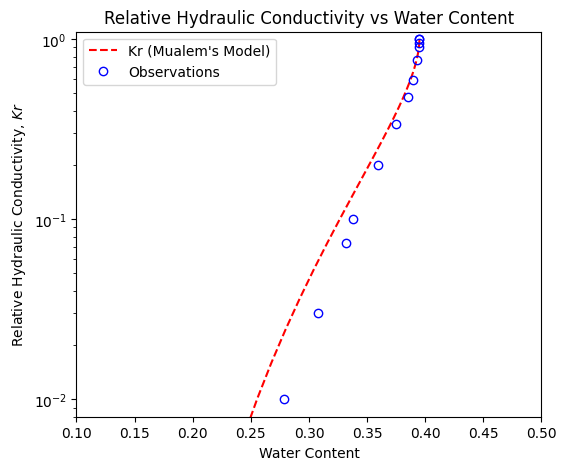

In [7]:
#-- Parameters --#
Ks = 4.96
tr = params["tr"]
ts = params["ts"]
alpha = params["alpha"]
n = params["n"]
print(f"The fitted value for the residual soil-water content is {tr}, the saturated soil-water "
      f"content is {ts}, the alpha is {alpha} and the n is {n}")

#-- pressure head values --#
h_obs = relativeK["Pressure Head"]
h_model = np.logspace(0, 5, 100)

#-- Calculation of the water content --#
t_values_obs = [soil_water_content(tr, ts, alpha, h, n) for h in h_obs]
t_values_model = [soil_water_content(tr, ts, alpha, h, n) for h in h_model]
T_values = [water_content(alpha, h, n) for h in h_model]

#-- Calculation of the relative hydraulic conductivity --#
Kr_T, Kr_h = zip(*[relative_hydraulic_conductivity(alpha, n, h, T) for h, T in zip(h_model, T_values)])
Kr_T = list(Kr_T)  
Kr_h = list(Kr_h) 

plt.figure(figsize=(6, 5))
plt.plot(t_values_model, Kr_T, label="Kr (Mualem's Model)", c="red", linestyle='dashed')  
plt.plot(t_values_obs, relativeK["Relative Hydraulic Conductivity"], 'o', mfc='none', 
         label="Observations", c="blue")
plt.yscale('log')
plt.xlim(0.1, 0.5)
plt.ylim(0.008, 1.1)
plt.xlabel('Water Content')
plt.ylabel('Relative Hydraulic Conductivity, $Kr$')
plt.title('Relative Hydraulic Conductivity vs Water Content')
plt.legend(loc=2)
plt.show()

—Discuss it here—